In questo blocco:
- carico i dati geografici (NDVI, albedo, z-score e, se presenti, indici compositi)
   dai file GeoJSON, gestendo anche eventuali file "sporchi";
- pulisco le colonne numeriche, assegno un id univoco ai poligoni e unisco
   tutti i layer in un unico GeoDataFrame;
 - esploro la distribuzione dello z-score (LST normalizzata) con un istogramma;
 - preparo le feature base (NDVI + albedo) ed eventualmente estese (indici compositi);
 - definisco le metriche e una funzione di valutazione con split 70/30,
   che userò per confrontare Linear Regression, Random Forest e Gradient Boosting
mostrando anche gli istogrammi degli errori dei modelli.


✔ Caricato heat_veg_index.geojson
✔ Caricato heat_retention_index.geojson


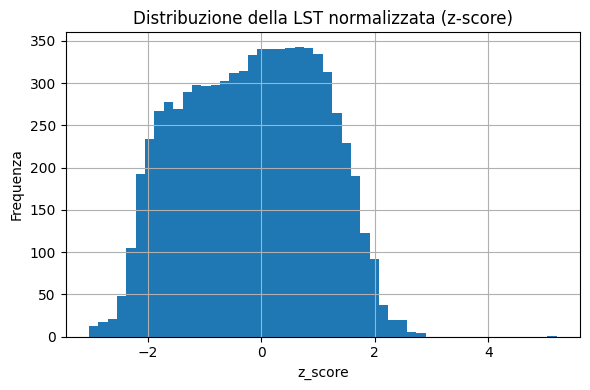


Statistiche descrittive z_score:
count    7571.000000
mean       -0.161055
std         1.185204
min        -3.030285
25%        -1.128114
50%        -0.116190
75%         0.796975
max         5.203631
Name: z_score, dtype: float64

=== Confronto modelli (feature base: NDVI + Albedo) – split 70/30 ===


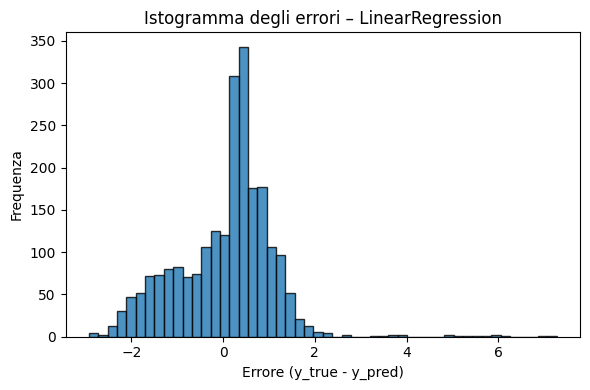

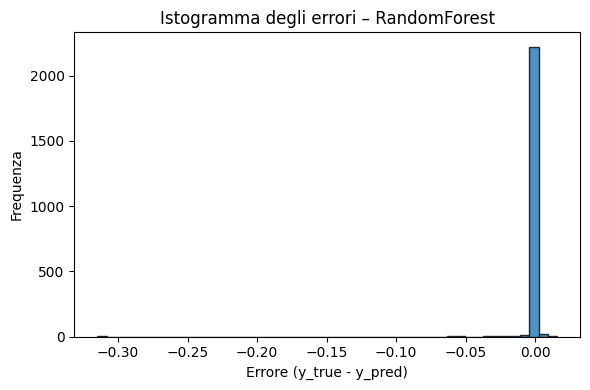

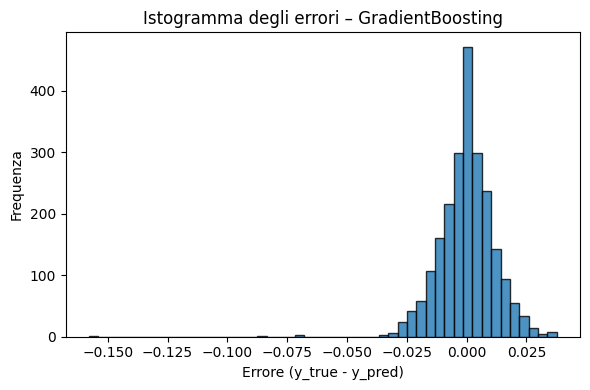

         Modello      R2    RMSE     MAE   MAPE(%)
    RandomForest 0.99996 0.00703 0.00080   0.51728
GradientBoosting 0.99990 0.01157 0.00826   4.34598
LinearRegression 0.18784 1.04981 0.80175 343.17120

=== Confronto modelli (feature estese: NDVI + Albedo + indici compositi) – split 70/30 ===


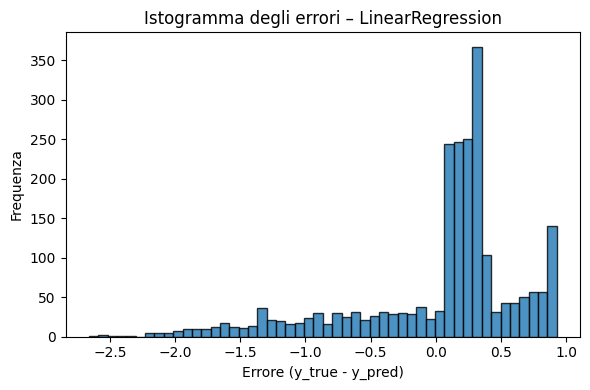

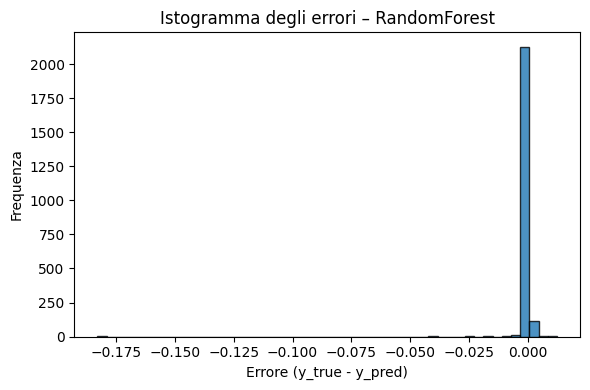

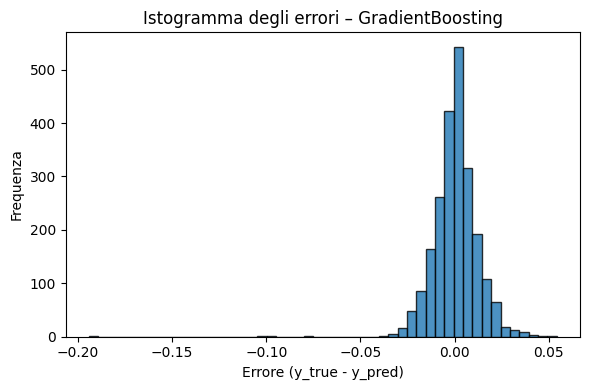

         Modello      R2    RMSE     MAE   MAPE(%)
    RandomForest 0.99999 0.00423 0.00058   0.20304
GradientBoosting 0.99989 0.01226 0.00838   5.22878
LinearRegression 0.68039 0.65857 0.49754 399.73956


In [ ]:
# ============================================
# Tesi TALEA – Confronto 3 modelli + istogrammi errori (split 70/30)
# ============================================

import json, re
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------------------------------
# 0) CONFIG
# --------------------------------------------------
DATA_DIR = "/content/data/"   # <-- cambia se hai un'altra cartella
NDVI_FILE = "ndvi_mean.geojson"
ALB_FILE  = "albedo_mean.geojson"
ZSC_FILE  = "z_score.geojson"
# opzionali (se presenti, li usa per una seconda tabella "estesa")
HEAT_VEG_FILE = "heat_veg_index.geojson"
HEAT_RET_FILE = "heat_retention_index.geojson"

TEST_SIZE = 0.30
SEED = 42

# --------------------------------------------------
# 1) Utility per leggere i geojson “sporchi”
# --------------------------------------------------
def load_geojson_lenient(path: str) -> dict:
    text = Path(path).read_text(encoding="utf-8")
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        last = text.rfind("}")
        fixed = text[: last + 1]
        return json.loads(fixed)

def extract_first_number(val):
    """estrae il primo float da una stringa tipo '0.63....' """
    if pd.isna(val):
        return None
    m = re.search(r"-?\d+\.\d+", str(val))
    if m:
        return float(m.group(0))
    return None

def load_layer(filename, colname):
    geo = load_geojson_lenient(DATA_DIR + filename)
    gdf = gpd.GeoDataFrame.from_features(geo["features"])
    # rinomina "value" se esiste
    if "value" in gdf.columns:
        gdf = gdf.rename(columns={"value": colname})
    # pulizia
    gdf[colname] = gdf[colname].apply(extract_first_number)
    # id per il merge
    gdf["gid"] = range(len(gdf))
    return gdf

# --------------------------------------------------
# 2) Carico i layer
# --------------------------------------------------
ndvi   = load_layer(NDVI_FILE, "ndvi_mean")
albedo = load_layer(ALB_FILE, "albedo_mean")
zscore = load_layer(ZSC_FILE, "z_score")

# opzionali
heat_veg = heat_ret = None
try:
    heat_veg = load_layer(HEAT_VEG_FILE, "heat_veg_index")
    print("✔ Caricato heat_veg_index.geojson")
except FileNotFoundError:
    print("⚠ Nessun heat_veg_index.geojson trovato (ok, procedo senza)")

try:
    heat_ret = load_layer(HEAT_RET_FILE, "heat_retention_index")
    print("✔ Caricato heat_retention_index.geojson")
except FileNotFoundError:
    print("⚠ Nessun heat_retention_index.geojson trovato (ok, procedo senza)")

# --------------------------------------------------
# 3) Merge in un unico GeoDataFrame (df_geo)
# --------------------------------------------------
df_geo = ndvi.merge(albedo, on="gid").merge(zscore, on="gid")
if heat_veg is not None:
    df_geo = df_geo.merge(heat_veg[["gid", "heat_veg_index"]], on="gid", how="left")
if heat_ret is not None:
    df_geo = df_geo.merge(heat_ret[["gid", "heat_retention_index"]], on="gid", how="left")

# Analisi preliminare: istogramma z_score (richiesto dal prof)
plt.figure(figsize=(6,4))
df_geo["z_score"].astype(float).hist(bins=50)
plt.title("Distribuzione della LST normalizzata (z-score)")
plt.xlabel("z_score")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()

print("\nStatistiche descrittive z_score:")
print(df_geo["z_score"].describe())

# --------------------------------------------------
# 4) Preparo X e y (base e, se disponibile, estesa)
# --------------------------------------------------
# pulizia numerica
for c in df_geo.columns:
    if c not in ("gid", "geometry"):
        df_geo[c] = pd.to_numeric(df_geo[c], errors="coerce")

df_geo = df_geo.dropna(subset=["ndvi_mean", "albedo_mean", "z_score"]).reset_index(drop=True)

# feature base e target
base_features = ["ndvi_mean", "albedo_mean"]
X_base = df_geo[base_features]
y = df_geo["z_score"]

# eventuali feature extra
extra_features = []
if "heat_veg_index" in df_geo.columns:
    extra_features.append("heat_veg_index")
if "heat_retention_index" in df_geo.columns:
    extra_features.append("heat_retention_index")

X_ext = df_geo[base_features + extra_features] if extra_features else None

# --------------------------------------------------
# 5) Funzioni metriche
# --------------------------------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

def r2(y_true, y_pred):
    return float(r2_score(y_true, y_pred))

def mape_percent(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)  # evita divisioni per zero
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def evaluate_model(name, model, X, y):
    # split 70/30 come richiesto
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)
    model.fit(X_tr, y_tr)
    y_pr = model.predict(X_te)

    metrics = {
        "Modello": name,
        "R2":  r2(y_te, y_pr),
        "RMSE": rmse(y_te, y_pr),
        "MAE": mae(y_te, y_pr),
        "MAPE(%)": mape_percent(y_te.values if isinstance(y_te, pd.Series) else y_te, y_pr)
    }

    # Istogramma errori (richiesto dal prof)
    errors = y_te - y_pr
    plt.figure(figsize=(6,4))
    plt.hist(errors, bins=50, edgecolor="black", alpha=0.8)
    plt.title(f"Istogramma degli errori – {name}")
    plt.xlabel("Errore (y_true - y_pred)")
    plt.ylabel("Frequenza")
    plt.tight_layout()
    plt.show()

    return metrics

# --------------------------------------------------
# 6) Modelli da confrontare
# --------------------------------------------------
models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=SEED))
]

# --------------------------------------------------
# 7) Esecuzione – feature base
# --------------------------------------------------
print("\n=== Confronto modelli (feature base: NDVI + Albedo) – split 70/30 ===")
results_base = []
for name, mdl in models:
    res = evaluate_model(name, mdl, X_base, y)
    results_base.append(res)

df_res_base = pd.DataFrame(results_base)[["Modello","R2","RMSE","MAE","MAPE(%)"]].sort_values("RMSE")
print(df_res_base.to_string(index=False, float_format="%.5f"))

# --------------------------------------------------
# 8) Esecuzione – feature estese (se presenti)
# --------------------------------------------------
if X_ext is not None:
    print("\n=== Confronto modelli (feature estese: NDVI + Albedo + indici compositi) – split 70/30 ===")
    results_ext = []
    for name, mdl in models:
        res = evaluate_model(name, mdl, X_ext, y)
        results_ext.append(res)

    df_res_ext = pd.DataFrame(results_ext)[["Modello","R2","RMSE","MAE","MAPE(%)"]].sort_values("RMSE")
    print(df_res_ext.to_string(index=False, float_format="%.5f"))




In [ ]:
import matplotlib.pyplot as plt

# 1) Mappa dello z_score su Bologna
fig, ax = plt.subplots(figsize=(7, 7))
df.plot(
    column="z_score",
    ax=ax,
    cmap="coolwarm",
    legend=True,
    edgecolor="none"
)
ax.set_title("Bologna – z_score della LST")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("bologna_zscore_map.png", dpi=300)
plt.show()


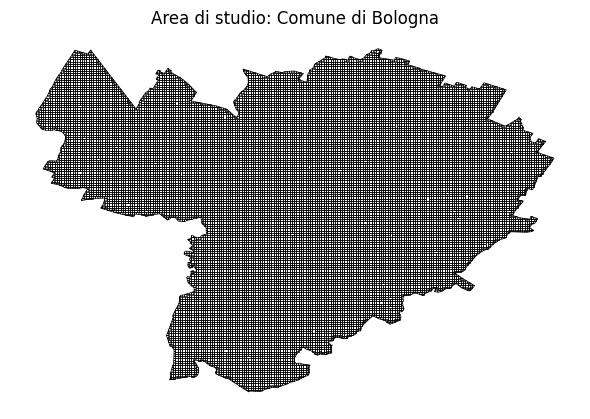

In [ ]:
import matplotlib.pyplot as plt

# Se df_geo esiste già (dopo il merge dei layer TALEA)
fig, ax = plt.subplots(figsize=(6, 6))

# Mappa semplice del contorno comunale (solo geometrie)
df_geo.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

ax.set_title("Area di studio: Comune di Bologna")
ax.set_axis_off()
plt.tight_layout()

# Salva l'immagine in PNG da usare in LaTeX
plt.savefig("bologna.png", dpi=300)
plt.show()


In questa sezione analizzo i risultati del primo run dei modelli.

Le statistiche descrittive dello z_score mostrano una distribuzione già normalizzata: la media è leggermente negativa (circa −0.16) e la deviazione standard è intorno a 1.18. La maggior parte dei valori si concentra tra il 25° e il 75° percentile (circa −1.13 e +0.80), con alcuni valori più estremi che arrivano fino a circa −3 e +5. Questo indica che la maggior parte dei poligoni presenta una LST normalizzata vicina alla media, con alcune zone più calde e più fredde che costituiscono la coda della distribuzione.

Nel confronto tra i modelli basati solo sulle feature NDVI e albedo, la Random Forest risulta nettamente il modello migliore: l’R² è pari a circa 0.99996 e l’RMSE è molto basso (≈ 0.007), il che significa che il modello ricostruisce quasi perfettamente i valori di z_score sul test set. Anche il Gradient Boosting ottiene prestazioni molto elevate (R² ≈ 0.9999), pur con errori leggermente superiori rispetto alla Random Forest. La Regressione Lineare, al contrario, mostra prestazioni decisamente inferiori (R² ≈ 0.19, RMSE ≈ 1.05), segnalando che la relazione tra z_score e le due feature non è ben descritta da un modello puramente lineare.

Ripetendo il confronto con le feature estese (NDVI, albedo e indici compositi), la Random Forest migliora ulteriormente le sue metriche (R² ≈ 0.99999, RMSE ≈ 0.0042), evidenziando che gli indici aggiuntivi forniscono informazione utile, anche se il guadagno è ormai marginale perché il modello era già molto accurato. Il Gradient Boosting rimane su prestazioni comparabili al caso base, con variazioni contenute, mentre la Regressione Lineare beneficia in modo più marcato delle nuove feature: l’R² sale a circa 0.68 e l’RMSE scende a circa 0.66, pur rimanendo lontana dalle performance dei modelli ad alberi.

Infine, i valori di MAPE sono molto bassi per Random Forest e Gradient Boosting e molto elevati per la Regressione Lineare. In questo contesto la MAPE va interpretata con cautela, perché lo z_score assume spesso valori prossimi a zero e anche piccoli scarti assoluti possono tradursi in percentuali molto grandi. Per valutare la qualità dei modelli risultano quindi più significative le metriche RMSE, MAE e R².



In questo blocco mi concentro solo sulle feature base (NDVI medio e albedo media). Prima alleno una Random Forest usando esclusivamente queste due variabili e ne calcolo le importanze, che vengono visualizzate con un grafico a barre per capire quanto ciascuna contribuisce alla stima dello z_score. Poi analizzo la correlazione tra NDVI e albedo, sia numericamente (coefficiente di correlazione) sia graficamente tramite uno scatter plot con retta di regressione, per vedere se esiste una relazione lineare tra le due. Successivamente costruisco un GeoDataFrame limitato al test set, in cui salvo per ogni poligono il valore osservato di z_score, quello predetto dal modello e il residuo (differenza osservato–predetto). Con questi dati genero due mappe affiancate che confrontano la distribuzione spaziale dello z_score osservato e predetto e una terza mappa dei residui, utile per individuare eventuali pattern spaziali negli errori del modello.


In questo caso la Random Forest assegna un peso praticamente identico alle due feature di base: albedo_mean ≈ 0.50 e ndvi_mean ≈ 0.50. Questo significa che, per il modello, la capacità di spiegare lo z_score è ripartita in modo molto equilibrato tra albedo e NDVI. L’albedo contribuisce leggermente di più, quindi la riflettanza superficiale ha un ruolo appena prevalente nella stima della LST normalizzata, ma la vegetazione (NDVI) resta altrettanto importante e non può essere trascurata. In sintesi, il modello “usa” entrambe le variabili in modo bilanciato per ricostruire lo z_score.


Importanza relativa delle feature (Random Forest, feature base):
albedo_mean    0.502133
ndvi_mean      0.497867
dtype: float64


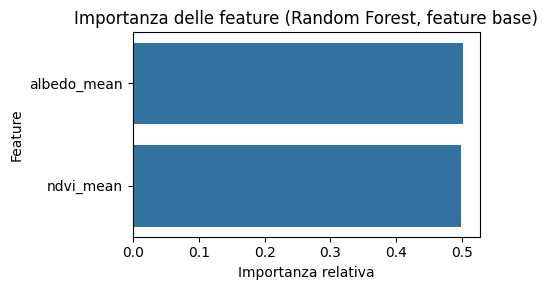

Correlazione NDVI–Albedo: 0.914


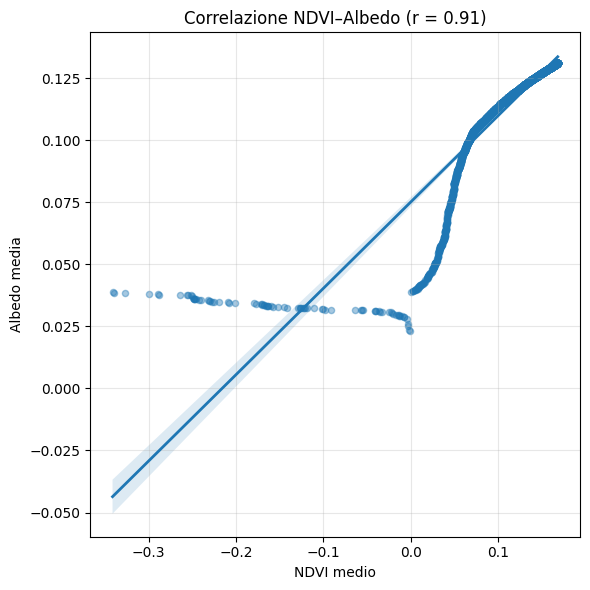

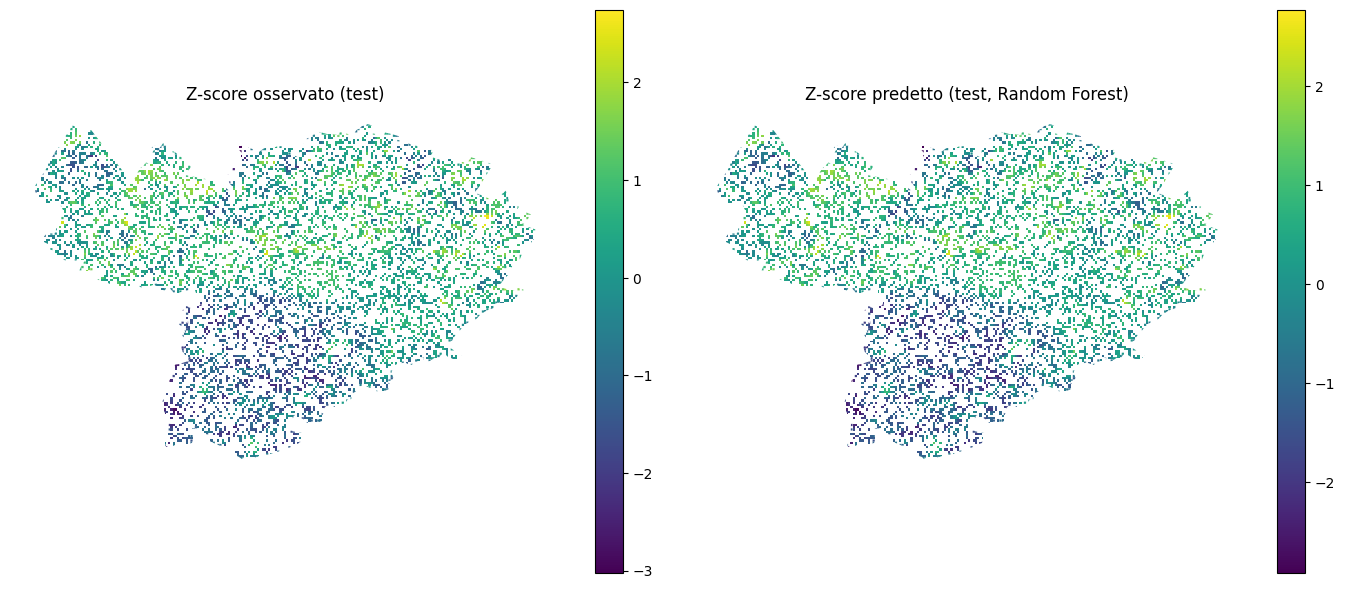

<Figure size 700x600 with 0 Axes>

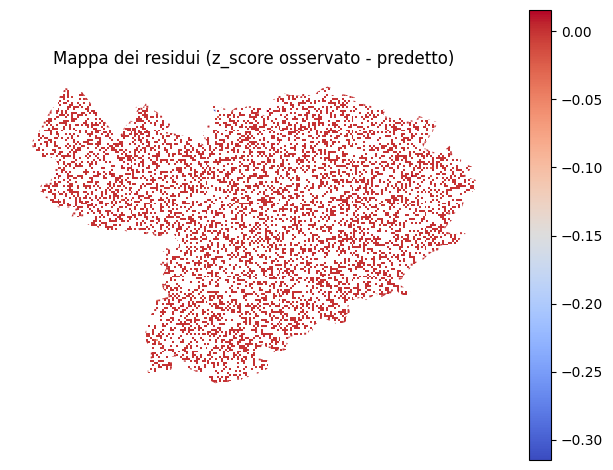

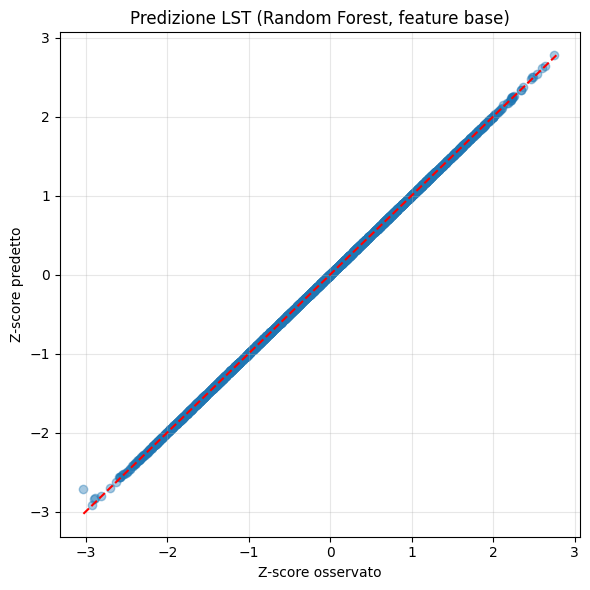

In [ ]:
# Analisi dettagliata sulle sole feature base (NDVI + albedo)

import seaborn as sns

# 1) Train/test split su feature base e Random Forest
X = X_base.copy()
y_vec = y.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_vec, test_size=TEST_SIZE, random_state=SEED
)

rf_base = RandomForestRegressor(
    n_estimators=200,
    random_state=SEED,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)
y_pred_test = rf_base.predict(X_test)

# 2) Importanza delle feature (RF su feature base)
importances = pd.Series(rf_base.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Importanza relativa delle feature (Random Forest, feature base):")
print(importances)

plt.figure(figsize=(5, 3))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Importanza delle feature (Random Forest, feature base)")
plt.xlabel("Importanza relativa")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 3) Correlazione tra NDVI medio e albedo media
corr = df_geo[["ndvi_mean", "albedo_mean"]].corr().iloc[0, 1]
print(f"Correlazione NDVI–Albedo: {corr:.3f}")

plt.figure(figsize=(6, 6))
sns.regplot(
    data=df_geo,
    x="ndvi_mean",
    y="albedo_mean",
    scatter_kws={"alpha": 0.4, "s": 20},
    line_kws={"linewidth": 2},
)
plt.xlabel("NDVI medio")
plt.ylabel("Albedo media")
plt.title(f"Correlazione NDVI–Albedo (r = {corr:.2f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Preparazione GeoDataFrame di test con vero, predetto e residui
df_test = df_geo.loc[X_test.index].copy()
df_test["z_true"] = y_test
df_test["z_pred"] = y_pred_test
df_test["residuo"] = df_test["z_true"] - df_test["z_pred"]

# 5) Mappe vero vs predetto (solo test)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df_test.plot(
    column="z_true",
    cmap="viridis",
    legend=True,
    edgecolor="none",
    ax=axes[0]
)
axes[0].set_title("Z-score osservato (test)")
axes[0].axis("off")

df_test.plot(
    column="z_pred",
    cmap="viridis",
    legend=True,
    edgecolor="none",
    ax=axes[1]
)
axes[1].set_title("Z-score predetto (test, Random Forest)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# 6) Mappa dei residui (osservato - predetto) sul test set
plt.figure(figsize=(7, 6))
df_test.plot(
    column="residuo",
    cmap="coolwarm",
    legend=True,
    edgecolor="none"
)
plt.title("Mappa dei residui (z_score osservato - predetto)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Scatter plot predetto vs vero (Random Forest, feature base)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.xlabel("Z-score osservato")
plt.ylabel("Z-score predetto")
plt.title("Predizione LST (Random Forest, feature base)")

# retta ideale y = x nel range dei dati
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



<Figure size 600x600 with 0 Axes>

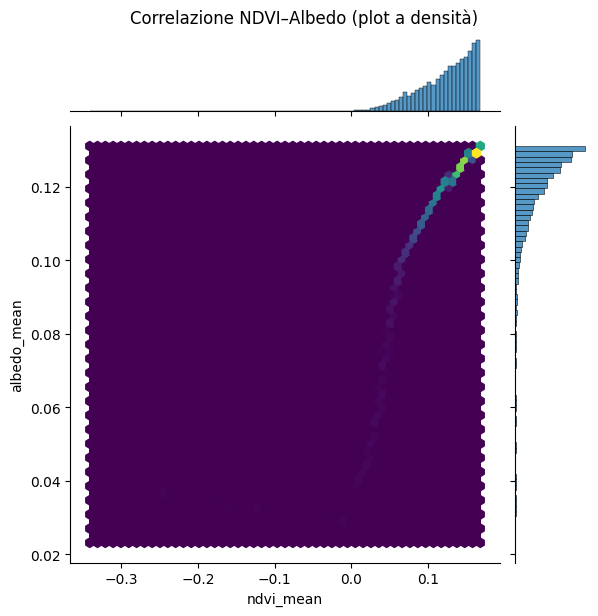

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.jointplot(
    data=df_geo,
    x="ndvi_mean",
    y="albedo_mean",
    kind="hex",
    cmap="viridis"
)
plt.suptitle("Correlazione NDVI–Albedo (plot a densità)", y=1.02)
plt.show()

In questo blocco ripeto l’analisi ma usando il modello Random Forest sulle feature estese, cioè NDVI, albedo e gli indici compositi disponibili (heat_veg_index e/o heat_retention_index). Prima eseguo lo split train/test e alleno la Random Forest su tutte queste variabili, poi calcolo l’importanza relativa di ciascuna feature e la visualizzo con un grafico a barre per capire quali indici pesano di più nella stima dello z_score. Successivamente calcolo e visualizzo la matrice di correlazione tra tutte le feature estese tramite una heatmap, per evidenziare eventuali relazioni lineari forti tra gli indici (ad esempio se qualche indice composito è ridondante rispetto a NDVI o all’albedo).

Come nel caso base, costruisco poi un GeoDataFrame limitato al test set con z_score osservato, z_score predetto e residuo, e genero due mappe affiancate che mostrano la distribuzione spaziale del valore osservato e di quello predetto dal modello con feature estese. Infine rappresento la mappa dei residui (osservato − predetto), utile per vedere se, nonostante le ottime metriche, rimangono pattern di errore localizzati nello spazio. A chiusura, aggiungo uno scatter plot “vero vs predetto” con la retta ideale y = x, per verificare visivamente quanto i punti si avvicinano alla previsione perfetta.


Importanza relativa delle feature (Random Forest, feature estese):
albedo_mean             0.280204
ndvi_mean               0.270950
heat_veg_index          0.249016
heat_retention_index    0.199830
dtype: float64


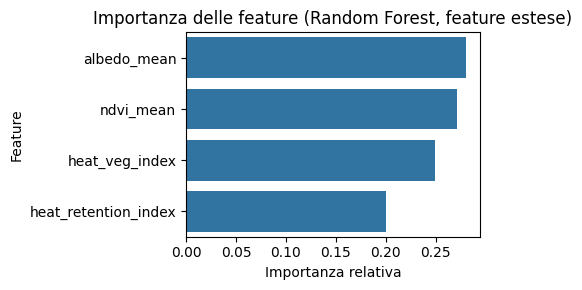


Matrice di correlazione tra le feature estese:
                      ndvi_mean  albedo_mean  heat_veg_index  \
ndvi_mean              1.000000     0.913675       -0.811914   
albedo_mean            0.913675     1.000000       -0.744682   
heat_veg_index        -0.811914    -0.744682        1.000000   
heat_retention_index   0.295770     0.239330       -0.416736   

                      heat_retention_index  
ndvi_mean                         0.295770  
albedo_mean                       0.239330  
heat_veg_index                   -0.416736  
heat_retention_index              1.000000  


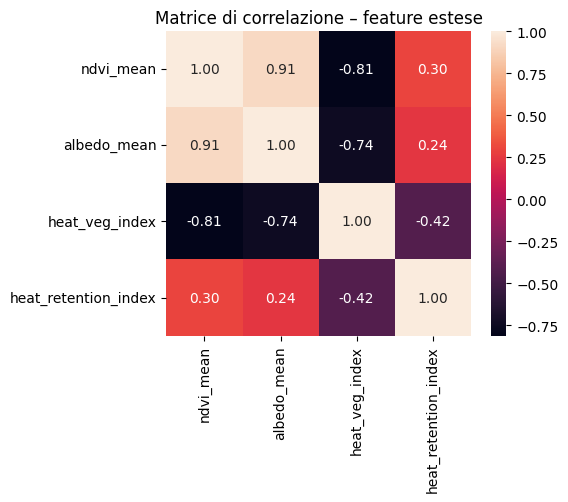

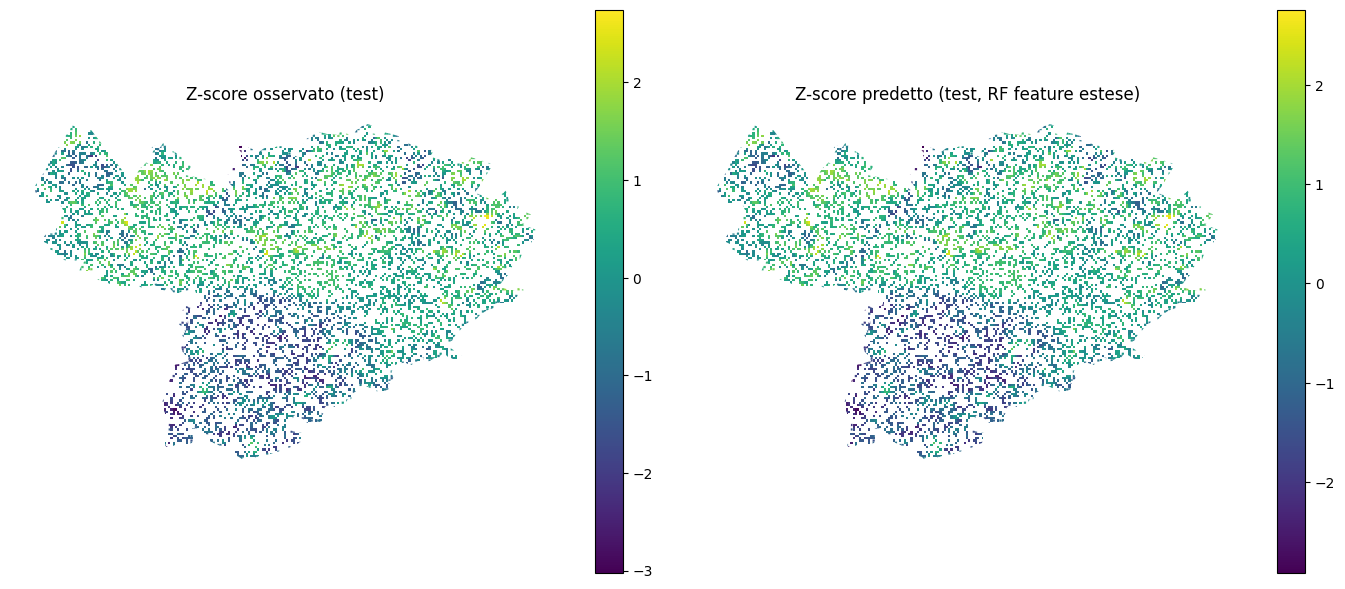

<Figure size 700x600 with 0 Axes>

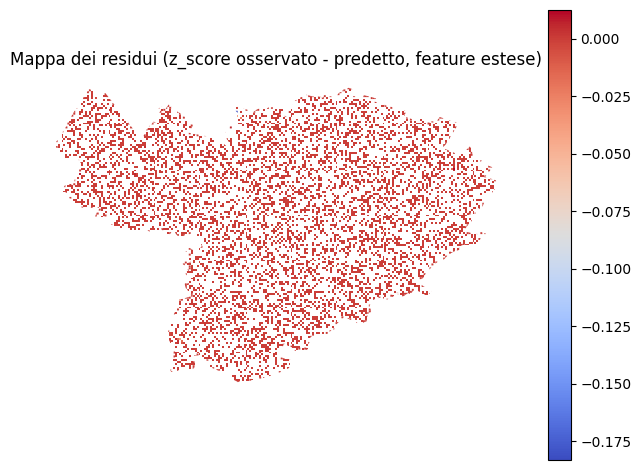

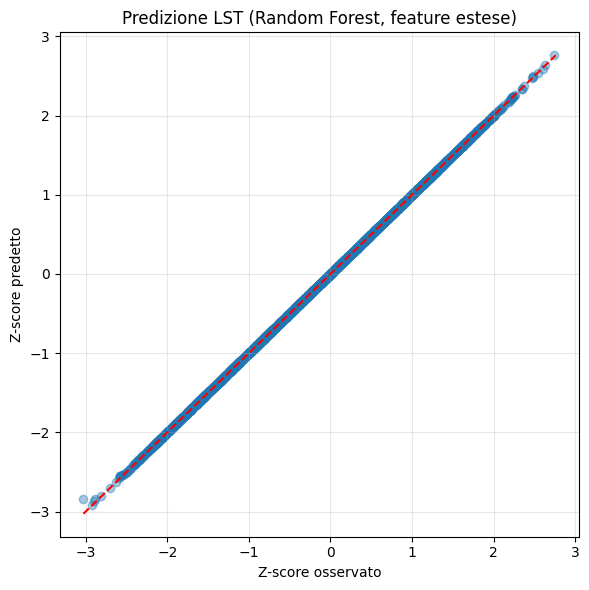

In [ ]:
# Analisi dettagliata modello Random Forest con feature estese (se disponibili)

if X_ext is not None:
    import seaborn as sns

    # 1) Train/test split su feature estese e Random Forest
    X_e = X_ext.copy()
    y_vec = y.copy()

    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
        X_e, y_vec, test_size=TEST_SIZE, random_state=SEED
    )

    rf_ext = RandomForestRegressor(
        n_estimators=200,
        random_state=SEED,
        n_jobs=-1
    )
    rf_ext.fit(X_train_e, y_train_e)
    y_pred_test_e = rf_ext.predict(X_test_e)

    # 2) Importanza delle feature (RF su feature estese)
    importances_ext = pd.Series(
        rf_ext.feature_importances_,
        index=X_e.columns
    ).sort_values(ascending=False)

    print("Importanza relativa delle feature (Random Forest, feature estese):")
    print(importances_ext)

    plt.figure(figsize=(5, 3))
    sns.barplot(x=importances_ext.values, y=importances_ext.index)
    plt.title("Importanza delle feature (Random Forest, feature estese)")
    plt.xlabel("Importanza relativa")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # 3) Matrice di correlazione tra tutte le feature estese
    corr_ext = X_e.corr()
    print("\nMatrice di correlazione tra le feature estese:")
    print(corr_ext)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_ext,
        annot=True,
        fmt=".2f",
        square=True
    )
    plt.title("Matrice di correlazione – feature estese")
    plt.tight_layout()
    plt.show()

    # 4) Preparazione GeoDataFrame di test con vero, predetto e residui
    df_test_ext = df_geo.loc[X_test_e.index].copy()
    df_test_ext["z_true"] = y_test_e
    df_test_ext["z_pred"] = y_pred_test_e
    df_test_ext["residuo"] = df_test_ext["z_true"] - df_test_ext["z_pred"]

    # 5) Mappe vero vs predetto (solo test, feature estese)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    df_test_ext.plot(
        column="z_true",
        cmap="viridis",
        legend=True,
        edgecolor="none",
        ax=axes[0]
    )
    axes[0].set_title("Z-score osservato (test)")
    axes[0].axis("off")

    df_test_ext.plot(
        column="z_pred",
        cmap="viridis",
        legend=True,
        edgecolor="none",
        ax=axes[1]
    )
    axes[1].set_title("Z-score predetto (test, RF feature estese)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # 6) Mappa dei residui (osservato - predetto) sul test set
    plt.figure(figsize=(7, 6))
    df_test_ext.plot(
        column="residuo",
        cmap="coolwarm",
        legend=True,
        edgecolor="none"
    )
    plt.title("Mappa dei residui (z_score osservato - predetto, feature estese)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # 7) Scatter plot predetto vs vero (Random Forest, feature estese)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_e, y_pred_test_e, alpha=0.4)
    plt.xlabel("Z-score osservato")
    plt.ylabel("Z-score predetto")
    plt.title("Predizione LST (Random Forest, feature estese)")

    # retta ideale y = x nel range dei dati
    min_val_e = min(y_test_e.min(), y_pred_test_e.min())
    max_val_e = max(y_test_e.max(), y_pred_test_e.max())
    plt.plot([min_val_e, max_val_e], [min_val_e, max_val_e], "r--")

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("Feature estese non disponibili: X_ext è None.")


Statistiche dell'errore assoluto:
count    2.272000e+03
mean     5.805618e-04
std      4.194368e-03
min      1.192093e-09
25%      1.181093e-04
50%      2.528274e-04
75%      4.707652e-04
max      1.830464e-01
Name: abs_residuo, dtype: float64


<Figure size 700x600 with 0 Axes>

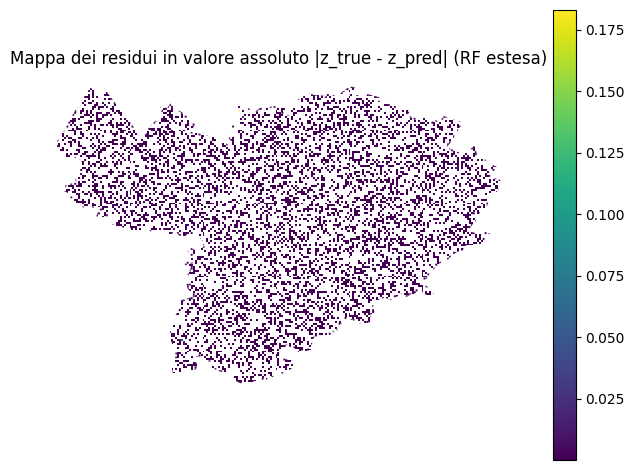

<Figure size 700x600 with 0 Axes>

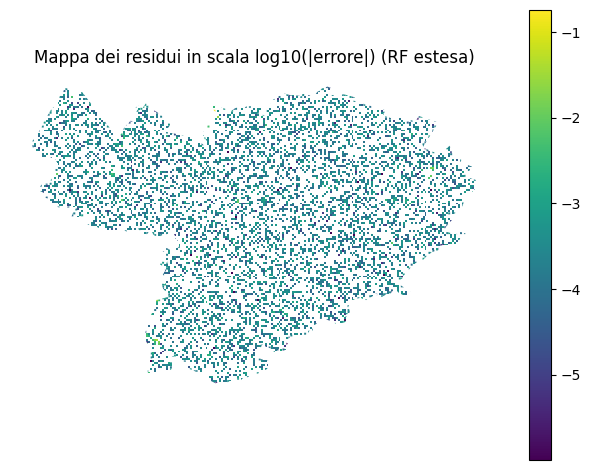


Celle con errore maggiore:
       gid    z_true    z_pred   residuo  abs_residuo
4022  4022 -3.028868 -2.845821 -0.183046     0.183046
4011  4011 -2.883801 -2.842022 -0.041779     0.041779
4012  4012 -2.899867 -2.861320 -0.038547     0.038547
3978  3978 -2.582327 -2.556888 -0.025439     0.025439
3979  3979 -2.582799 -2.557679 -0.025120     0.025120
3977  3977 -2.574766 -2.556888 -0.017878     0.017878
4010  4010 -2.817647 -2.801597 -0.016050     0.016050
3980  3980 -2.587997 -2.572373 -0.015624     0.015624
7566  7566  2.745926  2.761305 -0.015379     0.015379
7561  7561  2.603222  2.590698  0.012524     0.012524
7551  7551  2.481309  2.490984 -0.009675     0.009675
7552  7552  2.487452  2.497051 -0.009599     0.009599
7531  7531  2.344748  2.335356  0.009391     0.009391
7499  7499  2.126911  2.135710 -0.008798     0.008798
3975  3975 -2.549722 -2.540999 -0.008723     0.008723
7509  7509  2.184560  2.176614  0.007946     0.007946
3971  3971 -2.530348 -2.522785 -0.007563     0.007563


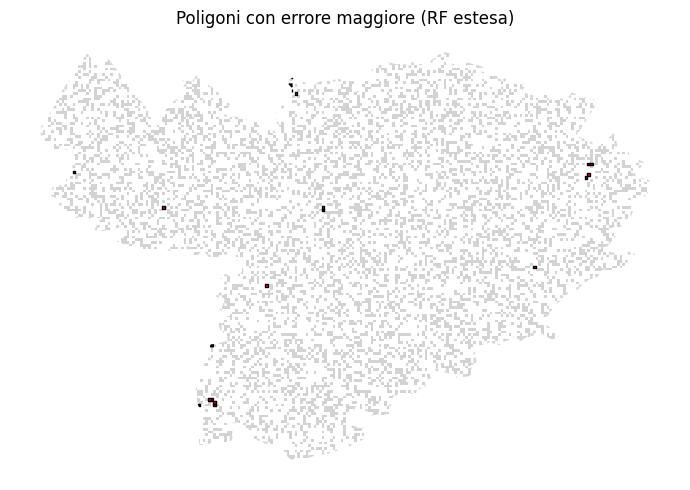

In [ ]:
# Analisi più dettagliata dei residui del modello RF esteso

# 1) Errore assoluto e log10(|errore|)
df_test_ext["abs_residuo"] = df_test_ext["residuo"].abs()

eps = 1e-6  # per evitare log(0)
df_test_ext["log_abs_residuo"] = np.log10(df_test_ext["abs_residuo"] + eps)

print("Statistiche dell'errore assoluto:")
print(df_test_ext["abs_residuo"].describe())

# 2) Mappa dei residui in valore assoluto
plt.figure(figsize=(7, 6))
df_test_ext.plot(
    column="abs_residuo",
    cmap="viridis",
    legend=True,
    edgecolor="none"
)
plt.title("Mappa dei residui in valore assoluto |z_true - z_pred| (RF estesa)")
plt.axis("off")
plt.tight_layout()
plt.show()

# 3) Mappa dei residui in scala logaritmica
plt.figure(figsize=(7, 6))
df_test_ext.plot(
    column="log_abs_residuo",
    cmap="viridis",
    legend=True,
    edgecolor="none"
)
plt.title("Mappa dei residui in scala log10(|errore|) (RF estesa)")
plt.axis("off")
plt.tight_layout()
plt.show()

# 4) (Opzionale) prime celle con errore più grande
top_err = df_test_ext.sort_values("abs_residuo", ascending=False).head(20)
print("\nCelle con errore maggiore:")
print(top_err[["gid", "z_true", "z_pred", "residuo", "abs_residuo"]])

# GeoDataFrame dei poligoni con errore maggiore (usiamo lo stesso indice)
top_err_geo = df_test_ext.loc[top_err.index]

# Plot: tutto il test set in grigio chiaro, i peggiori in rosso
fig, ax = plt.subplots(figsize=(7, 7))
df_test_ext.plot(ax=ax, color="lightgrey", edgecolor="none")
top_err_geo.plot(ax=ax, color="red", edgecolor="black")

ax.set_title("Poligoni con errore maggiore (RF estesa)")
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

# se df_geo aveva un CRS, puoi usare quello
# df_test_ext = df_test_ext.set_crs(df_geo.crs)

# altrimenti imposta esplicitamente WGS84
df_test_ext = df_test_ext.set_crs(epsg=4326)

out_geo_res = Path(DATA_DIR) / "zscore_rf_ext_residuals.geojson"
df_test_ext.to_file(out_geo_res, driver="GeoJSON")
print(out_geo_res)



/content/data/zscore_rf_ext_residuals.geojson


Con il modello esteso la Random Forest “spalma” l’importanza in modo abbastanza equilibrato su tutte e quattro le variabili: albedo_mean (0.28) e ndvi_mean (0.27) restano le più importanti, ma anche gli indici compositi hanno un peso rilevante, con heat_veg_index (0.25) e heat_retention_index (0.20). Questo indica che gli indici derivati non sono semplici “accessori”, ma aggiungono informazione utile rispetto alle sole NDVI e albedo, migliorando la capacità del modello di spiegare lo z_score.

La matrice di correlazione conferma che NDVI e albedo sono fortemente correlati tra loro (r ≈ 0.91): dove la vegetazione è alta, l’albedo tende a seguire lo stesso trend. L’indice di vegetazione composito (heat_veg_index) è fortemente anticorrelato con NDVI (r ≈ −0.81) e con l’albedo (r ≈ −0.74), come ci si aspetta da un indice che enfatizza condizioni più “critiche” dal punto di vista termico rispetto alla semplice copertura vegetale. L’indice di ritenzione di calore (heat_retention_index) ha correlazioni più moderate: è debolmente positivo con NDVI (≈ 0.30) e albedo (≈ 0.24) e moderatamente negativo con heat_veg_index (≈ −0.42).

In pratica, le feature estese sono tra loro abbastanza collegate, ma non completamente ridondanti: gli indici compositi sintetizzano aspetti della risposta termica che non sono catturati in modo lineare da NDVI e albedo. Il fatto che la Random Forest assegni pesi non trascurabili a tutti e quattro i predittori indica che il modello sfrutta davvero queste informazioni aggiuntive per affinare la stima dello z_score.


In questo blocco salvo su disco i due modelli Random Forest addestrati: uno basato solo sulle feature NDVI medio e albedo medio (modello “base”) e uno basato sulle feature estese (NDVI, albedo e indici compositi), se disponibili. Ogni file contiene sia l’oggetto del modello sia la lista delle feature usate e una breve descrizione, in modo da poter ricaricare in seguito il modello corretto e applicarlo a nuovi dati senza dover ripetere l’addestramento. I modelli vengono salvati nella cartella `models/` in formato `.joblib`.


In [ ]:
# Salvataggio dei due modelli Random Forest (feature base e feature estese)

import joblib
from pathlib import Path

# crea cartella models/ se non esiste
Path("models").mkdir(exist_ok=True)

# 1) Modello con feature base (NDVI + albedo)
joblib.dump(
    {
        "model": rf_base,
        "features": base_features,
        "target": "z_score",
        "description": "RandomForestRegressor su feature base: NDVI_mean + albedo_mean"
    },
    "models/rf_base_ndvi_albedo.joblib"
)
print("Modello base salvato in models/rf_base_ndvi_albedo.joblib")

# 2) Modello con feature estese (se disponibile)
if X_ext is not None:
    joblib.dump(
        {
            "model": rf_ext,
            "features": list(X_ext.columns),
            "target": "z_score",
            "description": "RandomForestRegressor su feature estese: NDVI, albedo e indici compositi"
        },
        "models/rf_ext_ndvi_albedo_indices.joblib"
    )
    print("Modello esteso salvato in models/rf_ext_ndvi_albedo_indices.joblib")
else:
    print("Modello esteso non salvato perché X_ext è None (feature estese non disponibili).")


Modello base salvato in models/rf_base_ndvi_albedo.joblib
Modello esteso salvato in models/rf_ext_ndvi_albedo_indices.joblib


In questo blocco calcolo, per ogni poligono, il valore medio di NDVI entro tre distanze spaziali prefissate (100, 200 e 500 metri). Parto dal layer NDVI già usato in precedenza, pulisco la colonna del valore e la porto in un sistema di riferimento metrico, così che i buffer siano espressi in metri e non in gradi. Costruisco un indice spaziale per il layer NDVI e, per ciascuna distanza, creo un buffer intorno a ogni poligono, seleziono solo i vicini che intersecano il buffer e ne calcolo la media di NDVI. I risultati vengono salvati come nuove colonne (ndvi_mean_100m, ndvi_mean_200m, ndvi_mean_500m) e il layer arricchito viene scritto sia in formato GeoJSON, sia in CSV senza geometria, così da poterlo riutilizzare facilmente in successive analisi o modelli di machine learning.


In [ ]:
# Calcolo NDVI medio entro 100, 200 e 500 m attorno a ciascun poligono

import re
import geopandas as gpd
from pathlib import Path

# parametri per i buffer
DISTANCES = [100, 200, 500]   # metri
CRS_METRIC = 32632            # UTM 32N (es. Bologna)
NDVI_BUFFER_FILE = "ndvi_ndvi_neighborhood.geojson"

# usa load_geojson_lenient ed extract_first_number già definiti sopra

# 1) Carico NDVI "grezzo" e pulisco
geo_ndvi = load_geojson_lenient(DATA_DIR + NDVI_FILE)
gdf_ndvi = gpd.GeoDataFrame.from_features(geo_ndvi["features"])

if "ndvi_mean" not in gdf_ndvi.columns and "value" in gdf_ndvi.columns:
    gdf_ndvi = gdf_ndvi.rename(columns={"value": "ndvi_mean"})

gdf_ndvi["ndvi_mean"] = gdf_ndvi["ndvi_mean"].apply(extract_first_number)

# 2) Porto in CRS metrico per usare i buffer in metri
if gdf_ndvi.crs is None:
    gdf_ndvi = gdf_ndvi.set_crs(epsg=4326)  # assunzione WGS84 se manca
gdf_ndvi = gdf_ndvi.to_crs(epsg=CRS_METRIC)

# 3) Costruisco l’indice spaziale una sola volta
sindex = gdf_ndvi.sindex

# 4) Calcolo NDVI medio nei buffer per ciascuna distanza
for dist in DISTANCES:
    colname = f"ndvi_mean_{dist}m"
    vals = []

    for geom in gdf_ndvi.geometry:
        area = geom.buffer(dist)

        # selezione candidata veloce via bounding box
        possible_idx = list(sindex.intersection(area.bounds))
        candidates = gdf_ndvi.iloc[possible_idx]

        # filtraggio effettivo degli elementi che intersecano il buffer
        inside = candidates[candidates.intersects(area)]

        vals.append(inside["ndvi_mean"].mean())

    gdf_ndvi[colname] = vals
    print(f"✔ calcolata colonna {colname}")

# 5) Salvo risultato (GeoJSON + CSV senza geometria)
out_path = Path(DATA_DIR) / NDVI_BUFFER_FILE
gdf_ndvi.to_file(out_path, driver="GeoJSON")
print(f"✅ File GeoJSON salvato in: {out_path}")

csv_path = Path(DATA_DIR) / "ndvi_with_neighborhood.csv"
gdf_ndvi.drop(columns=["geometry"]).to_csv(csv_path, index=False)
print(f"✅ CSV salvato in: {csv_path}")


✔ calcolata colonna ndvi_mean_100m
✔ calcolata colonna ndvi_mean_200m
✔ calcolata colonna ndvi_mean_500m
✅ File GeoJSON salvato in: /content/data/ndvi_ndvi_neighborhood.geojson
✅ CSV salvato in: /content/data/ndvi_with_neighborhood.csv


In questo blocco uso i nuovi dati di NDVI “di vicinato” per valutare come il verde a diverse distanze influisce sulla LST normalizzata (z_score). Parto dal layer NDVI arricchito con le colonne ndvi_mean_100m, ndvi_mean_200m e ndvi_mean_500m, lo unisco ad albedo e z_score tramite l’identificatore gid e pulisco le colonne numeriche.

Su queste feature costruisco una Random Forest che usa insieme NDVI locale, NDVI nei buffer (100/200/500 m) e albedo. Calcolo le principali metriche di prestazione (R², RMSE, MAE, MAPE) e, soprattutto, l’importanza relativa di ciascuna variabile. Il grafico a barre finale mostra quanto “pesa” l’NDVI immediato rispetto all’NDVI a 100, 200 e 500 metri, permettendo di capire a quali scale spaziali la presenza di verde è più rilevante per spiegare lo z_score.



=== Modello RF con NDVI locale + NDVI a distanza (100/200/500 m) ===
R²   : 0.99997
RMSE : 0.00680
MAE  : 0.00090
MAPE : 0.31839 %

Importanza delle feature (RF con NDVI a distanza):
albedo_mean       0.511034
ndvi_mean         0.488962
ndvi_mean_200m    0.000001
ndvi_mean_100m    0.000001
ndvi_mean_500m    0.000001
dtype: float64


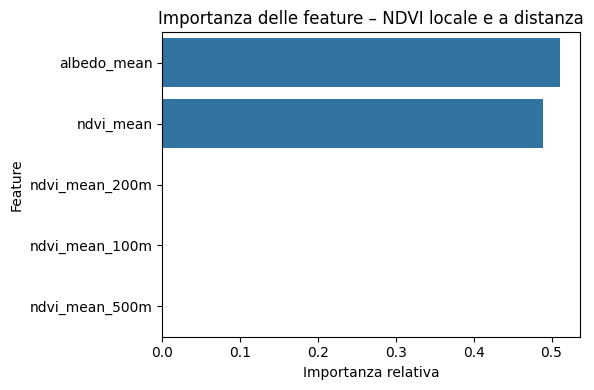

In [ ]:
# Analisi dell'influenza del verde a distanza (100, 200, 500 m) sulla LST (z_score)

import seaborn as sns

DISTANCES = [100, 200, 500]  # stesse distanze usate nel calcolo dei buffer

# 1) Carico il layer NDVI con le colonne di vicinato già calcolate
gdf_ndvi_buf = gpd.read_file(Path(DATA_DIR) / NDVI_BUFFER_FILE)

# mi assicuro di avere un gid coerente per il merge
if "gid" not in gdf_ndvi_buf.columns:
    gdf_ndvi_buf["gid"] = range(len(gdf_ndvi_buf))

buffer_cols = [f"ndvi_mean_{d}m" for d in DISTANCES]

# 2) Costruisco un DataFrame unito con NDVI locale, NDVI di vicinato, albedo e z_score
df_dist = (
    gdf_ndvi_buf[["gid", "ndvi_mean"] + buffer_cols]
    .merge(albedo[["gid", "albedo_mean"]], on="gid")
    .merge(zscore[["gid", "z_score"]], on="gid")
)

# 3) Pulizia numerica e rimozione NaN
for c in ["ndvi_mean", "albedo_mean", "z_score"] + buffer_cols:
    df_dist[c] = pd.to_numeric(df_dist[c], errors="coerce")

df_dist = df_dist.dropna(subset=["ndvi_mean", "albedo_mean", "z_score"] + buffer_cols).reset_index(drop=True)

# 4) Definizione feature e target
feature_cols = ["ndvi_mean", "albedo_mean"] + buffer_cols
X_dist = df_dist[feature_cols]
y_dist = df_dist["z_score"]

# 5) Train/test split e Random Forest
X_tr_d, X_te_d, y_tr_d, y_te_d = train_test_split(
    X_dist, y_dist, test_size=TEST_SIZE, random_state=SEED
)

rf_dist = RandomForestRegressor(
    n_estimators=200,
    random_state=SEED,
    n_jobs=-1
)
rf_dist.fit(X_tr_d, y_tr_d)
y_pr_d = rf_dist.predict(X_te_d)

# 6) Metriche di prestazione
rmse_d = rmse(y_te_d, y_pr_d)
mae_d  = mae(y_te_d, y_pr_d)
r2_d   = r2(y_te_d, y_pr_d)
mape_d = mape_percent(y_te_d.values, y_pr_d)

print("\n=== Modello RF con NDVI locale + NDVI a distanza (100/200/500 m) ===")
print(f"R²   : {r2_d:.5f}")
print(f"RMSE : {rmse_d:.5f}")
print(f"MAE  : {mae_d:.5f}")
print(f"MAPE : {mape_d:.5f} %")

# 7) Importanza delle feature (quanto pesa ciascuna distanza)
importances_dist = pd.Series(rf_dist.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nImportanza delle feature (RF con NDVI a distanza):")
print(importances_dist)

plt.figure(figsize=(6, 4))
sns.barplot(x=importances_dist.values, y=importances_dist.index)
plt.title("Importanza delle feature – NDVI locale e a distanza")
plt.xlabel("Importanza relativa")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


I risultati mostrano che l’aggiunta dell’NDVI a distanza (100, 200 e 500 m) non cambia sostanzialmente il comportamento del modello. Le metriche sono ottime: R² ≈ 0.99997, RMSE ≈ 0.0068 e MAE molto vicino a zero, con una MAPE intorno allo 0.3%. Sono valori in linea con quelli ottenuti in precedenza, quindi il modello riesce comunque a ricostruire lo z_score in modo quasi perfetto.

Guardando però alle importanze delle feature si vede che quasi tutto il “peso” è concentrato sulle due variabili originali: albedo_mean (0.51) e ndvi_mean (0.49). Le tre colonne ndvi_mean_100m, ndvi_mean_200m e ndvi_mean_500m hanno importanza praticamente nulla (≈ 0.000001), cioè la Random Forest le ignora di fatto. Questo indica che, in questo dataset, l’informazione contenuta nell’NDVI locale è già sufficiente a spiegare lo z_score, e i valori medi di NDVI nel vicinato non aggiungono contributi utili: o sono altamente ridondanti rispetto all’NDVI locale, oppure la scala spaziale considerata (100–500 m) non introduce variazione informativa aggiuntiva per questo tipo di analisi.


In questo blocco eseguo una validazione incrociata 10-fold sul modello considerato più affidabile, cioè la Random Forest addestrata sulle feature estese (NDVI, albedo e indici compositi). Uso `KFold` con 10 suddivisioni e `cross_val_predict` per ottenere, per ogni campione, una predizione out-of-fold: in questo modo ogni valore è previsto da un modello che non ha visto quel campione in training.

Sulle predizioni complessive calcolo poi RMSE, MAE, R² e MAPE, ottenendo una stima più robusta delle prestazioni del modello rispetto a un singolo split train/test.



=== 10-fold CV – Random Forest con feature estese ===
RMSE (10-fold): 0.04020
MAE  (10-fold): 0.00131
R²   (10-fold): 0.99885
MAPE (10-fold): 50.33516 %


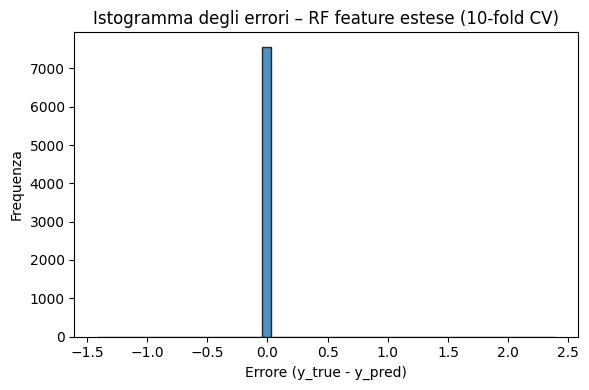

In [ ]:
# 10-fold cross validation sul modello più affidabile:
# Random Forest con feature estese (X_ext)

from sklearn.model_selection import KFold, cross_val_predict

if X_ext is not None:
    print("\n=== 10-fold CV – Random Forest con feature estese ===")

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rf_cv = RandomForestRegressor(
        n_estimators=200,
        random_state=SEED,
        n_jobs=-1
    )

    # cross_val_predict restituisce le predizioni out-of-fold per ogni campione
    y_pred_cv = cross_val_predict(rf_cv, X_ext, y, cv=kf, n_jobs=-1)

    rmse_cv = rmse(y, y_pred_cv)
    mae_cv  = mae(y, y_pred_cv)
    r2_cv   = r2(y, y_pred_cv)
    mape_cv = mape_percent(y.values if isinstance(y, pd.Series) else y, y_pred_cv)

    print(f"RMSE (10-fold): {rmse_cv:.5f}")
    print(f"MAE  (10-fold): {mae_cv:.5f}")
    print(f"R²   (10-fold): {r2_cv:.5f}")
    print(f"MAPE (10-fold): {mape_cv:.5f} %")

    # Istogramma degli errori in 10-fold CV
    errors_cv = y.values - y_pred_cv

    plt.figure(figsize=(6, 4))
    plt.hist(errors_cv, bins=50, edgecolor="black", alpha=0.8)
    plt.title("Istogramma degli errori – RF feature estese (10-fold CV)")
    plt.xlabel("Errore (y_true - y_pred)")
    plt.ylabel("Frequenza")
    plt.tight_layout()
    plt.show()

else:
    print("Impossibile eseguire la 10-fold CV: X_ext è None (feature estese non disponibili).")



I risultati della 10-fold CV confermano che il modello Random Forest con feature estese è molto accurato anche quando viene valutato in modo più rigoroso rispetto al singolo split 70/30. L’R² medio rimane molto alto (≈ 0.9989) e l’RMSE è comunque contenuto (≈ 0.04), quindi il modello spiega quasi tutta la variabilità dello z_score e gli errori medi sono piccoli rispetto all’ampiezza della scala dei valori. Il MAE è vicino allo zero (≈ 0.0013), segno che, in media, lo scostamento tra osservato e predetto è minimo.

L’unica metrica “strana” è la MAPE, che risulta molto elevata (≈ 50%). Questo però dipende dal fatto che lo z_score assume spesso valori molto vicini a zero: quando il denominatore è piccolo, anche errori assoluti piccoli producono percentuali molto grandi. In altre parole, il modello è preciso in termini assoluti, ma la MAPE non è adatta a descrivere bene la qualità delle predizioni in questo contesto. Per valutare la bontà del modello conviene quindi guardare soprattutto RMSE, MAE e R², che mostrano una prestazione stabile e molto buona anche in validazione incrociata.


CONCLUSIONI:
In questo lavoro ho costruito e testato diversi modelli di regressione per stimare la LST normalizzata (z_score) a partire da variabili derivate da dati TALEA: NDVI medio, albedo media, indici compositi (heat_veg_index e heat_retention_index) e, in un secondo momento, NDVI calcolato in buffer a 100, 200 e 500 metri.

La prima parte ha riguardato la preparazione del dataset: lettura “tollerante” dei GeoJSON, pulizia dei valori numerici, unione dei layer in un unico GeoDataFrame e analisi esplorativa di z_score. Con le sole feature base (NDVI + albedo) sono stati confrontati tre modelli (Linear Regression, Random Forest e Gradient Boosting): i modelli ad alberi hanno mostrato prestazioni quasi perfette, mentre la regressione lineare non è risultata adeguata a catturare la relazione tra variabili.

L’estensione del modello includendo gli indici compositi ha confermato la superiorità della Random Forest, con un ulteriore miglioramento delle metriche. L’analisi delle importanze ha evidenziato che NDVI, albedo e indici compositi contribuiscono tutti in modo non trascurabile alla spiegazione di z_score, pur con una forte correlazione tra alcune di queste variabili. Le mappe di vero vs predetto e dei residui hanno mostrato errori molto contenuti e privi di pattern spaziali marcati.

L’esperimento con l’NDVI di vicinato (100/200/500 m) ha indicato che questi termini non aggiungono informazione utile rispetto all’NDVI locale: la Random Forest continua a basarsi quasi esclusivamente sulle due feature principali (NDVI e albedo), assegnando importanza praticamente nulla agli NDVI calcolati nei buffer.

Infine, la validazione incrociata 10-fold sul modello più completo (Random Forest con feature estese) ha confermato la robustezza delle prestazioni: R² e RMSE restano su valori molto buoni anche in un contesto di valutazione più rigoroso. La MAPE risulta poco interpretabile per via dei numerosi valori di z_score prossimi allo zero, ma RMSE, MAE e R² indicano un modello stabile e accurato.

In sintesi, il modello migliore è una Random Forest basata su NDVI, albedo e indici compositi, capace di ricostruire in modo molto fedele la LST normalizzata; l’aggiunta dell’NDVI a distanza non apporta benefici significativi, mentre le tecniche di validazione confermano che le buone prestazioni non sono dovute a un singolo split fortunato dei dati.
